코드 생성

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [103]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [104]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [105]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [106]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        self.code_freq = code_freq
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        self.t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * self.t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       
    def shift(self, tvar):
        self.t = self.t + tvar
        self.seq = np.roll(self.seq, -tvar)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (self.doppler + self.code_freq) * self.t / (1.023e6 * OV))
        

Replica 신호 생성

In [107]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, ts, tvar):
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        #temp1 = np.arange((1023 * OV * ts + tvar), (1023 * OV * ts + tvar + complement)) 
        #temp2 = np.arange((1023 * OV * ts + tvar + complement), (1023 * OV * ts + tvar + 1023* OV)) 
        t = np.arange((1023 * OV * ts + tvar), (1023 * OV * ts + tvar + 1023 * OV))
        # if tvar != 0:
        #    print(temp1[0], temp1[-1], temp2[0], temp2[-1])
        self.delayed_code = np.roll(ca_code, code_delay)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

Acquisition

In [108]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 0, 0)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
    
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
          
    return max_code_delay, max_doppler_freq, corr_matrix, dop_freq_max
    

Acquisition 실행

In [109]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
true_code_delay = 10230 * 5 + 6500
true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = 4500

received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
B = true_code_delay//(OV*1023)
print("B :", B)
print()
# for i in range(-10,11):
#    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 650.0
Estimated_Frequency Offset : -2500.0
Max correlation : 1289.1798162539776
----------------------------------------

------------------ Test ------------------
Target SV Number: 10
True Code Delay: 5765.0
True doppler frequency: -2532
----------------------------------------
B : 5



In [110]:
received_signal.shift(estimated_code_delay)
sig = received_signal.signal()
# complement = 1023*OV - max_code_delay
signal_div = []
"""for i in range(0, len(sig), 1023 * OV):
    if i == len(sig) - 1023*OV:
        temp1 = sig[i+max_code_delay:] 
        print('lastbit')
        temp2 = sig[0:max_code_delay]
    else:
        temp1 = sig[i+max_code_delay:i+max_code_delay + complement]
        temp2 = sig[i+max_code_delay + complement:i+max_code_delay + 1023*OV]
    res = np.concatenate((temp1, temp2))
    signal_div.append(res) """
signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i, estimated_code_delay)
    #print(True_replica)
    #print(signal_div[i])
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))

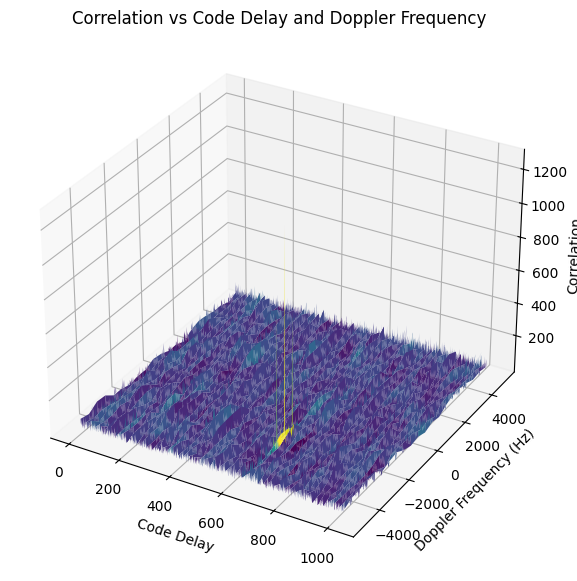

In [111]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [112]:
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
# R = cor_lst[0] * np.conjugate(cor_lst[-1])
# phase_diff.append(np.arctan2(np.imag(R), np.real(R)))
degree_list = [np.degrees(value) for value in phase_diff]

Index 0: 10.320786869574542
Index 1: 11.442494404856443
Index 2: 12.670895461239471
Index 3: 9.529291214719668
Index 4: 12.339543167739535
Index 5: 10.910717997392544
Index 6: 11.283064152080785
Index 7: 11.620873321637724
Index 8: 11.632170123242702
Index 9: 13.585734079307834
Index 10: 9.628054352662513
Index 11: 12.307383203222347
Index 12: 11.504223907245603
Index 13: 10.903957643163384
Index 14: 11.9878969565346
Index 15: 11.83471830736127
Index 16: 10.203051519146051
Index 17: 10.842220589164171
Index 18: 12.65632195927715
Index 19: 12.098739116899148
Index 20: 11.538153559693267
Index 21: 10.767414757923337
Index 22: 11.278836658023069
Index 23: 11.638509287340426
Index 24: -167.4336663716712
Index 25: 12.256581107047875
Index 26: 10.206139491276371
Index 27: 10.24726786893277
Index 28: 13.626227533537397
Index 29: 10.1261641072245
Index 30: 9.664478545088548
Index 31: 14.651080582706436
Index 32: 9.4749147382613
Index 33: 13.70420905787375
Index 34: 11.4246715324694
Index 35: 1

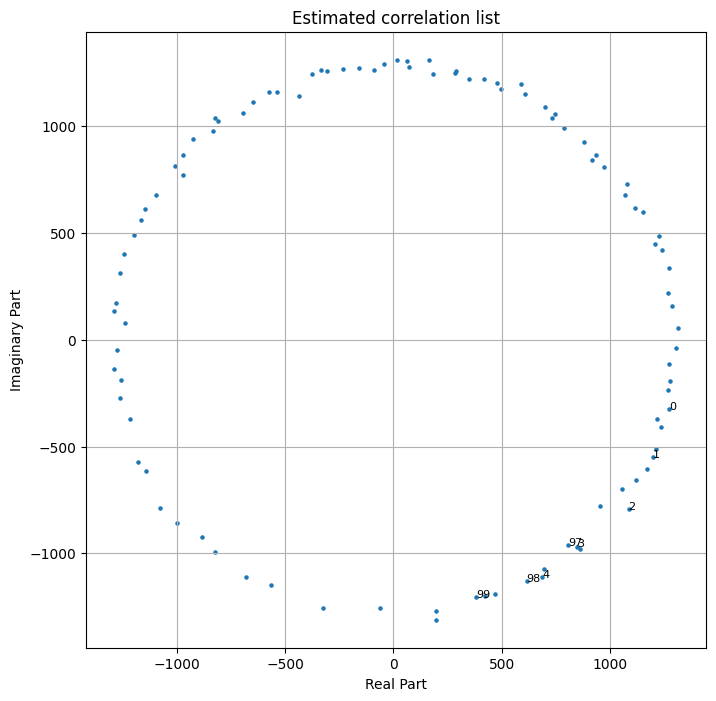

In [113]:

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")



plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(97, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)
    
for i, txt in enumerate(range(0, 0 + B)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
        
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [114]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [15, 85])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers


# data = degree_list

outliers = find_outliers(degree_list)
print("이상치:", outliers)

outlier_index = 0
if len(outliers)>=1:
    tmp = outliers[0]
    print("첫번째 이상치", tmp)
    idx = degree_list.index(tmp)

    outlier_index = idx + 1
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index % 20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    
print()

def find_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]
    return outliers

dl = degree_list[20:40]
outliers_z = find_outliers_z_score(dl)
print("참고: 이상치 (Z-Score):", outliers_z)

이상치: [-167.4336663716712, -168.15738074247622, -168.61560914323715, -168.5728271065709]
첫번째 이상치 -167.4336663716712
원래 25
estimated B 5
B 5

참고: 이상치 (Z-Score): [(24, -167.4336663716712)]


In [115]:
received_signal.shift(1023*OV * outlier_index)
sig = received_signal.signal()
# complement = 1023*OV - max_code_delay
signal_div = []
signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i, 1023 *OV* outlier_index +estimated_code_delay)
    #print(True_replica)
    #print(signal_div[i])
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))
    
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
# R = cor_lst[0] * np.conjugate(cor_lst[-1])
# phase_diff.append(np.arctan2(np.imag(R), np.real(R)))
degree_list = [np.degrees(value) for value in phase_diff]

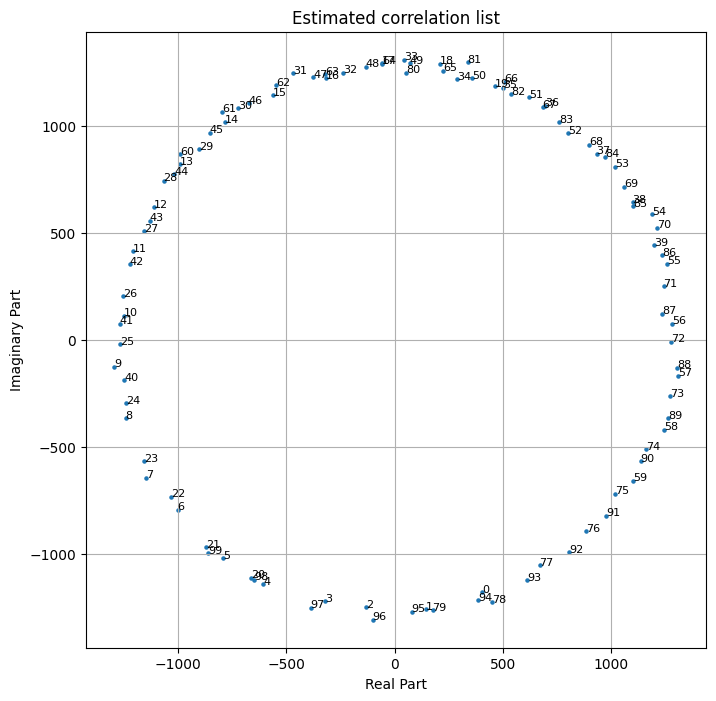

In [116]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(0, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

In [117]:
mean_diff_p = []
for i in range(ms//20):
    mean = np.average(phase_diff[i*20: i*20 + 18])
    print(mean)
    mean_diff_p.append(mean)

#mean_diff = [np.average(mean_diff_p)] * (ms//20)
# mean_diff_p[4] = mean_diff_p[3]

0.20175171527026417
0.20238111399477055
0.20088365380374473
0.20234698546663593
0.20123582228528933


1 bit change
2 bit change
3 bit change
4 bit change
[1, -1, 1, -1, 1] 5


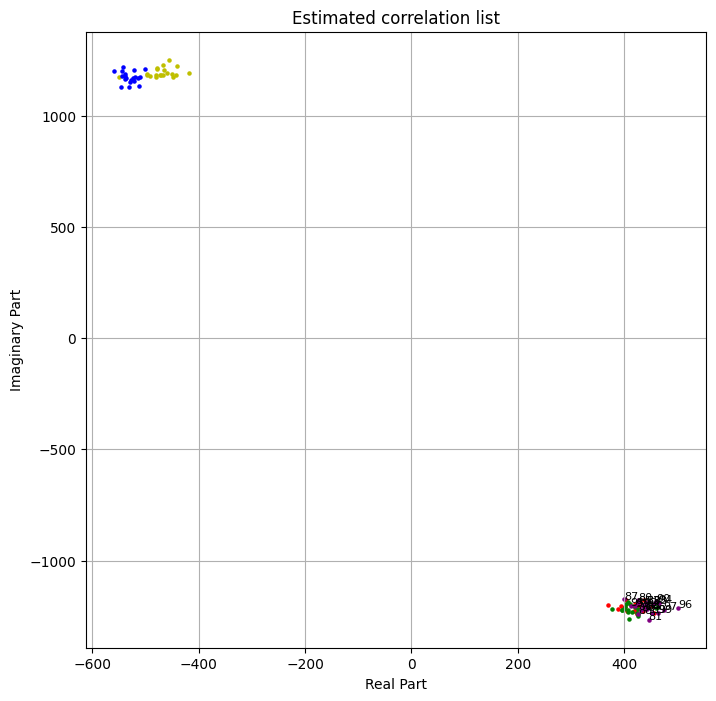

In [118]:

import cmath
# cumulative_phase = 0
new_result = []
cur_no = 0
phase_change = 0
for i in range(ms//20):
    new = [0] * 20
    if i == 0:
        # cur_no += 1
        # [0] = cor_lst[0]
        for j in range(len(cor_lst[:20])):
            current_phase = mean_diff_p[i] * cur_no 
            new[j] = cor_lst[j] * np.exp(1j * current_phase)
            cur_no += 1
    elif i != 0:
        if abs((degree_list[(20 * i) - 1])-(degree_list[20*i])) > 45:
            phase_change += 1
            print(i, "bit change")
        for j in range(20):
            current_phase = mean_diff_p[i] * cur_no  # + np.pi * phase_change
            new[j] = cor_lst[20 * i + j] * np.exp(1j * current_phase)
            cur_no += 1
    new_result += new
    
plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_result[:20]), np.imag(new_result[:20]), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_result[20:40]), np.imag(new_result[20:40]), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_result[40:60]), np.imag(new_result[40:60]), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_result[60:80]), np.imag(new_result[60:80]), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_result[80:100]), np.imag(new_result[80:100]), s=5, label='New_s_5', c='purple')
# plt.scatter(np.real(new_result[100:120]), np.imag(new_result[100:120]), s=5, label='New_s_6', c='black')

print(data, B)

for i, txt in enumerate(range(80, ms)):
    plt.annotate(f'{txt}', (np.real(new_result[i+80]), np.imag(new_result[i+80])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
# m = max(np.real(new_result[:]))
# plt.xlim(-1.1*m, 1.1*m)
# plt.ylim(-1.1*m, 1.1*m)
plt.grid(True)
plt.show()

In [119]:
for i, p in enumerate(degree_list):
    print(i, p)

0 12.31769986148265
1 12.564476478800808
2 8.754851063046727
3 13.238305704641506
4 9.865860928517515
5 13.814902416226763
6 9.049137577334497
7 12.933712194328711
8 10.840745257387049
9 10.76829098511848
10 13.691134096864648
11 10.211824131600286
12 10.601994747022275
13 12.750853740664635
14 11.302149374025632
15 11.741538568486742
16 11.904626047286813
17 11.719289128366249
18 12.074793281789118
19 -170.43493606575043
20 11.111853558485794
21 12.69622364586288
22 9.337344439369723
23 12.681391772540495
24 12.444450332147252
25 10.165947517129903
26 14.483057970047907
27 11.194775855633456
28 9.742261288400197
29 11.695623570885283
30 13.059657786798576
31 9.844665471099884
32 12.56543689970043
33 11.48427257386991
34 9.73648007302651
35 9.2956806171978
36 14.559700838759934
37 12.62168212005836
38 10.089173043892847
39 -168.17037823414924
40 12.014763837149236
41 12.774604557078463
42 10.014165909425248
43 11.03058918822144
44 11.393032127708898
45 10.006399263796315
46 14.32242245